In [1]:
import os
import pandas as pd
import tensorflow as tensorflow
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
import sklearn.metrics 
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,Dropout,GRU
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

In [2]:
train = pd.read_excel('inputAd.xlsx')
test = pd.read_excel('Test.xlsx')
train.text=train.text.astype(str)
#testSentimentText=test.text.astype(str)
df=pd.concat([train])
df1=pd.concat([test])

In [3]:
df1

,text,scoresplu,predictionplu,predictionbin,scoresbin
0,"сделал распределение счетов за хецнер и сдал, ...",NaN,NaN,NaN,NaN
1,Адаптация. Станислав объяснил принцип деплоя с...,NaN,NaN,NaN,NaN
2,"прослушал материал на тему ""сверточные нейронн...",NaN,NaN,NaN,NaN
3,Ознакомление с серверной инфраструктурой (nbt-...,NaN,NaN,NaN,NaN
4,"Работа над моделью, которая определяла бы соде...",NaN,NaN,NaN,NaN
5,Настройка подключения к MongoDB. Созвон с Миха...,NaN,NaN,NaN,NaN
6,Снова учил Алексея создавать стенды - скриптам...,NaN,NaN,NaN,NaN
7,Составление отчётов в Power BI по популярным з...,NaN,NaN,NaN,NaN
8,"Встреча с ДД, стратегия по набору людей в Депа...",NaN,NaN,NaN,NaN
9,"Подготовка материалов по ценообразованию,опрос...",NaN,NaN,NaN,NaN


In [4]:
key_metrics= {'samples' : len(train),
             'samples_per_class' : train['statusid'].value_counts().median(),
             'median_of_samples_lengths': np.median(train['text'].str.split().map(lambda x: len(x))),
             }
key_metrics = pd.DataFrame.from_dict(key_metrics, orient='index').reset_index()
key_metrics.columns = ['metric', 'value']
key_metrics

,metric,value
0,samples,3047.0
1,samples_per_class,377.0
2,median_of_samples_lengths,4.0


B:\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='statusid', ylabel='count'>

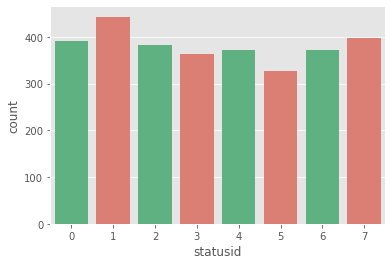

In [5]:
green = '#52BE80'
red = '#EC7063'
sns.countplot(train['statusid'], palette=[green, red])

B:\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='validdata', ylabel='count'>

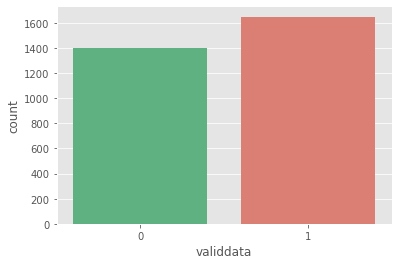

In [6]:
green = '#52BE80'
red = '#EC7063'
sns.countplot(train['validdata'], palette=[green, red])

In [7]:
blue = "#5DADE2"
def get_sentences_len_histogram(fig_size = (10,6), _class=None, color=blue):
    """make histogram of lengths of the tweets
    * _class : consider all the dataset
    - _class=0 only non disaster tweets
    - _class=1 only disaster tweets"""
    f, ax = plt.subplots(figsize=fig_size)
    if str(_class)=='None':
        tweets_len=train['text'].str.len()
        ax.set_title('tweets length')
        ax.hist(tweets_len,color=color)
    else: 
        tweets_len=train[train['statusid']==_class]['text'].str.len()
        ax.set_title(f'{_class} disaster tweets length ')
        ax.hist(tweets_len,color=color)

    return ax

def get_words_count_histogram(fig_size = (10,6), _class=None, color=blue):
    """make histogram of lengths of the tweets
    * _class : consider all the dataset
    - _class=0 only non disaster tweets
    - _class=1 only disaster tweets"""
    f, ax = plt.subplots(figsize=fig_size)
    if str(_class)=='None':
        tweets_len=train['text'].str.split().map(lambda x: len(x))
        ax.set_title('words counts by tweet')
        ax.hist(tweets_len,color=color)
    else: 
        tweets_len=train[train['statusid']==_class]['text'].str.split().map(lambda x: len(x))
        ax.set_title(f'words counts by  "{_class}" disaster tweets ')
        ax.hist(tweets_len,color=color)

    return ax

In [8]:
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
import re
mystem = Mystem() 
russian_stopwords = stopwords.words("russian")
english_stopwords = stopwords.words("english")

def preprocess_text(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords\
              and token != " " \
              and token.strip() not in punctuation]
    tokens = [token for token in tokens if token not in english_stopwords]

              

    text = " ".join(tokens)
    pattern3= r"[\d]"
    pattern2="[.]"
    text=re.sub(pattern3, "", text)
    text=re.sub(pattern2, "", text)
    if(text!='') and len(text)>3:
        return text
    else:
        return "#VALID!"

In [9]:
#srt = []
#srt.append("5637180087;SAP-155-002;Реализация;2021-01-20 00:00:00.000;1.000000000000;Рабочие встречи")
#for i in srt:
#    srt.append(preprocess_text(i))
df['cleaned_tweets'] = df['text'].apply(preprocess_text)
df1['cleaned_tweets'] = df1['text'].apply(preprocess_text)
#srt

In [10]:
train= df[~df['statusid'].isna()]
train['validdata'] = train['validdata'].astype(int)
train['statusid'] = train['statusid'].astype(int)
test = df1[~df1['text'].isna()]

In [11]:
 train['validdata']

0       1
1       1
2       1
3       1
4       1
       ..
3042    1
3043    0
3044    1
3045    0
3046    1
Name: validdata, Length: 3047, dtype: int32

In [12]:
test

,text,scoresplu,predictionplu,predictionbin,scoresbin,cleaned_tweets
0,"сделал распределение счетов за хецнер и сдал, ...",NaN,NaN,NaN,NaN,сделать распределение счет хецнер сдавать разб...
1,Адаптация. Станислав объяснил принцип деплоя с...,NaN,NaN,NaN,NaN,адаптация станислав объяснять принцип деплоить...
2,"прослушал материал на тему ""сверточные нейронн...",NaN,NaN,NaN,NaN,прослушивать материал тема сверточный нейронны...
3,Ознакомление с серверной инфраструктурой (nbt-...,NaN,NaN,NaN,NaN,ознакомление серверный инфраструктура nbt hvho...
4,"Работа над моделью, которая определяла бы соде...",NaN,NaN,NaN,NaN,работа модель который определять содержаться п...
5,Настройка подключения к MongoDB. Созвон с Миха...,NaN,NaN,NaN,NaN,настройка подключение mongodb созвон михаил чу...
6,Снова учил Алексея создавать стенды - скриптам...,NaN,NaN,NaN,NaN,снова учить алексей создавать стенд скрипт дел...
7,Составление отчётов в Power BI по популярным з...,NaN,NaN,NaN,NaN,составление отчет power bi популярный запрос п...
8,"Встреча с ДД, стратегия по набору людей в Депа...",NaN,NaN,NaN,NaN,встреча дд стратегия набор человек департамент
9,"Подготовка материалов по ценообразованию,опрос...",NaN,NaN,NaN,NaN,подготовка материал ценообразование опросный л...


In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3047 entries, 0 to 3046
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   text            3047 non-null   object 
 1   validdata       3047 non-null   int32  
 2   status          3047 non-null   object 
 3   statusid        3047 non-null   int32  
 4   score           0 non-null      float64
 5   cleaned_tweets  3047 non-null   object 
dtypes: float64(1), int32(2), object(3)
memory usage: 142.8+ KB


In [14]:
X_train, X_val, y_trainplu, y_valplu, y_trainbin, y_valbin = train_test_split(train, train['statusid'], train['validdata'], test_size=0.3, random_state=42)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_val.shape)

Shape of train (2132, 6)
Shape of Validation  (915, 6)


In [15]:
len(X_train)

2132

In [16]:
import tqdm as tqdm
import requests
import zipfile
URL = "http://nlp.stanford.edu/data/glove.42B.300d.zip"



def fetch_data(url=URL, target_file='glove.zip', delete_zip=False):
    #if the dataset already exists exit
    if os.path.isfile(target_file):
        print("datasets already downloded :) ")
        return

    #download (large) zip file
    #for large https request on stream mode to avoid out of memory issues
    #see : http://masnun.com/2016/09/18/python-using-the-requests-module-to-download-large-files-efficiently.html
    print("**************************")
    print("  Downloading zip file")
    print("  >_<  Please wait >_< ")
    print("**************************")
    response = requests.get(url, stream=True)
    #read chunk by chunk
    handle = open(target_file, "wb")
    for chunk in tqdm.tqdm(response.iter_content(chunk_size=512)):
        if chunk:  
            handle.write(chunk)
    handle.close()  
    print("  Download completed ;) :") 
    #extract zip_file
    zf = zipfile.ZipFile(target_file)
    print("1. Extracting {} file".format(target_file))
    zf.extractall()
    if delete_zip:
        print("2. Deleting {} file".format(dataset_name+".zip"))
        os.remove(path=zip_file)
        
fetch_data()

datasets already downloded :) 


In [17]:
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text

TOP_K = 20000

MAX_SEQUENCE_LENGTH = 50

class CustomTokenizer:
    def __init__(self, train_texts):
        self.train_texts = train_texts
        self.tokenizer = Tokenizer(num_words=TOP_K)
    def train_tokenize(self):
        # Get max sequence length.
        max_length = len(max(self.train_texts , key=len))
        self.max_length = min(max_length, MAX_SEQUENCE_LENGTH)
    
        # Create vocabulary with training texts.
        self.tokenizer.fit_on_texts(self.train_texts)
        
    def vectorize_input(self, tweets):
        # Vectorize training and validation texts.
        
        tweets = self.tokenizer.texts_to_sequences(tweets)
        # Fix sequence length to max value. Sequences shorter than the length are
        # padded in the beginning and sequences longer are truncated
        # at the beginning.
        tweets = sequence.pad_sequences(tweets, maxlen=self.max_length, truncating='post',padding='post')
        return tweets
    
tokenizer = CustomTokenizer(train_texts = X_train['cleaned_tweets'])
# fit o the train
tokenizer.train_tokenize()
tokenized_train = tokenizer.vectorize_input(X_train['cleaned_tweets'])
tokenized_val = tokenizer.vectorize_input(X_val['cleaned_tweets'])
tokenized_test = tokenizer.vectorize_input(test['cleaned_tweets'])

In [18]:
glove_file = "glove.42B.300d.txt"


EMBEDDING_VECTOR_LENGTH = 50 # <=200
def construct_embedding_matrix(glove_file, word_index):
    embedding_dict = {}
    with open(glove_file,'r',encoding='utf-8') as f:
        for line in f:
            values=line.split()
            # get the word
            word=values[0]
            if word in word_index.keys():
                # get the vector
                vector = np.asarray(values[1:], 'float32')
                embedding_dict[word] = vector
    ###  oov words (out of vacabulary words) will be mapped to 0 vectors

    num_words=len(word_index)+1
    #initialize it to 0
    embedding_matrix=np.zeros((num_words, EMBEDDING_VECTOR_LENGTH))

    for word,i in tqdm.tqdm(word_index.items()):
        if i < num_words:
            vect=embedding_dict.get(word, [])
            if len(vect)>0:
                embedding_matrix[i] = vect[:EMBEDDING_VECTOR_LENGTH]
    return embedding_matrix

embedding_matrix =  construct_embedding_matrix(glove_file, tokenizer.tokenizer.word_index)
print(embedding_matrix.shape)

100%|██████████| 1182/1182 [00:00<00:00, 592880.57it/s]

(1183, 50)


In [19]:
#https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model

from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [20]:
y_trainmatrix = tensorflow.keras.utils.to_categorical(y_trainplu, 9)
y_valmatrix = tensorflow.keras.utils.to_categorical(y_valplu, 9)

modelplu=Sequential()
optimzerplu=Adam(clipvalue=0.5)

modelplu.add(Embedding(len(tokenizer.tokenizer.word_index)+1, EMBEDDING_VECTOR_LENGTH, input_length=MAX_SEQUENCE_LENGTH,trainable=True))
modelplu.add(Dropout(0.2))
modelplu.add(LSTM(64, dropout=0.2, recurrent_dropout=0.5))
#model.add(GRU(64, return_sequences=True))
modelplu.add(Dense(9,activation='softmax'))
# compile the model
modelplu.compile(optimizer=optimzerplu, loss='categorical_crossentropy', metrics=['AUC'])

In [45]:
historyplu=modelplu.fit(tokenized_train, y_trainmatrix, 
                  batch_size=64, epochs=300, 
                  validation_data=(tokenized_val,y_valmatrix), 
                  verbose=2)

Epoch 1/300
34/34 - 1s - loss: 0.0381 - auc: 0.9994 - val_loss: 0.3127 - val_auc: 0.9831
Epoch 2/300
34/34 - 1s - loss: 0.0416 - auc: 0.9996 - val_loss: 0.3130 - val_auc: 0.9828
Epoch 3/300
34/34 - 1s - loss: 0.0389 - auc: 0.9996 - val_loss: 0.3029 - val_auc: 0.9832
Epoch 4/300
34/34 - 1s - loss: 0.0424 - auc: 0.9991 - val_loss: 0.3095 - val_auc: 0.9838
Epoch 5/300
34/34 - 1s - loss: 0.0356 - auc: 0.9997 - val_loss: 0.3117 - val_auc: 0.9828
Epoch 6/300
34/34 - 1s - loss: 0.0348 - auc: 0.9997 - val_loss: 0.2990 - val_auc: 0.9842
Epoch 7/300
34/34 - 1s - loss: 0.0335 - auc: 0.9999 - val_loss: 0.3165 - val_auc: 0.9822
Epoch 8/300
34/34 - 1s - loss: 0.0413 - auc: 0.9996 - val_loss: 0.3042 - val_auc: 0.9829
Epoch 9/300
34/34 - 1s - loss: 0.0365 - auc: 0.9994 - val_loss: 0.2990 - val_auc: 0.9834
Epoch 10/300
34/34 - 1s - loss: 0.0364 - auc: 0.9999 - val_loss: 0.3081 - val_auc: 0.9844
Epoch 11/300
34/34 - 1s - loss: 0.0335 - auc: 0.9999 - val_loss: 0.3236 - val_auc: 0.9821
Epoch 12/300
34/34 

34/34 - 1s - loss: 0.0364 - auc: 0.9996 - val_loss: 0.3149 - val_auc: 0.9826
Epoch 93/300
34/34 - 1s - loss: 0.0367 - auc: 0.9994 - val_loss: 0.2999 - val_auc: 0.9840
Epoch 94/300
34/34 - 1s - loss: 0.0345 - auc: 0.9999 - val_loss: 0.3136 - val_auc: 0.9826
Epoch 95/300
34/34 - 1s - loss: 0.0293 - auc: 0.9999 - val_loss: 0.3130 - val_auc: 0.9828
Epoch 96/300
34/34 - 1s - loss: 0.0321 - auc: 0.9997 - val_loss: 0.3140 - val_auc: 0.9840
Epoch 97/300
34/34 - 1s - loss: 0.0332 - auc: 0.9997 - val_loss: 0.3206 - val_auc: 0.9823
Epoch 98/300
34/34 - 1s - loss: 0.0311 - auc: 0.9999 - val_loss: 0.3273 - val_auc: 0.9827
Epoch 99/300
34/34 - 1s - loss: 0.0329 - auc: 0.9999 - val_loss: 0.3177 - val_auc: 0.9828
Epoch 100/300
34/34 - 1s - loss: 0.0329 - auc: 0.9997 - val_loss: 0.3167 - val_auc: 0.9822
Epoch 101/300
34/34 - 1s - loss: 0.0321 - auc: 0.9997 - val_loss: 0.3258 - val_auc: 0.9823
Epoch 102/300
34/34 - 1s - loss: 0.0344 - auc: 0.9997 - val_loss: 0.3318 - val_auc: 0.9815
Epoch 103/300
34/34 

Epoch 183/300
34/34 - 1s - loss: 0.0329 - auc: 0.9999 - val_loss: 0.3022 - val_auc: 0.9850
Epoch 184/300
34/34 - 1s - loss: 0.0355 - auc: 0.9991 - val_loss: 0.3033 - val_auc: 0.9836
Epoch 185/300
34/34 - 1s - loss: 0.0332 - auc: 0.9999 - val_loss: 0.3221 - val_auc: 0.9832
Epoch 186/300
34/34 - 1s - loss: 0.0345 - auc: 0.9997 - val_loss: 0.3201 - val_auc: 0.9832
Epoch 187/300
34/34 - 1s - loss: 0.0282 - auc: 0.9999 - val_loss: 0.3228 - val_auc: 0.9827
Epoch 188/300
34/34 - 1s - loss: 0.0334 - auc: 0.9999 - val_loss: 0.3242 - val_auc: 0.9821
Epoch 189/300
34/34 - 1s - loss: 0.0315 - auc: 0.9999 - val_loss: 0.3078 - val_auc: 0.9829
Epoch 190/300
34/34 - 1s - loss: 0.0320 - auc: 0.9999 - val_loss: 0.3121 - val_auc: 0.9833
Epoch 191/300
34/34 - 1s - loss: 0.0305 - auc: 0.9999 - val_loss: 0.3293 - val_auc: 0.9819
Epoch 192/300
34/34 - 1s - loss: 0.0315 - auc: 0.9999 - val_loss: 0.3309 - val_auc: 0.9823
Epoch 193/300
34/34 - 1s - loss: 0.0315 - auc: 0.9999 - val_loss: 0.3408 - val_auc: 0.9806

34/34 - 1s - loss: 0.0630 - auc: 0.9990 - val_loss: 0.3177 - val_auc: 0.9848
Epoch 274/300
34/34 - 1s - loss: 0.0639 - auc: 0.9989 - val_loss: 0.3216 - val_auc: 0.9836
Epoch 275/300
34/34 - 1s - loss: 0.0784 - auc: 0.9985 - val_loss: 0.2816 - val_auc: 0.9884
Epoch 276/300
34/34 - 1s - loss: 0.0823 - auc: 0.9988 - val_loss: 0.3446 - val_auc: 0.9838
Epoch 277/300
34/34 - 1s - loss: 0.0863 - auc: 0.9986 - val_loss: 0.2709 - val_auc: 0.9865
Epoch 278/300
34/34 - 1s - loss: 0.0557 - auc: 0.9988 - val_loss: 0.2931 - val_auc: 0.9851
Epoch 279/300
34/34 - 1s - loss: 0.0514 - auc: 0.9996 - val_loss: 0.2672 - val_auc: 0.9887
Epoch 280/300
34/34 - 1s - loss: 0.0558 - auc: 0.9993 - val_loss: 0.2850 - val_auc: 0.9863
Epoch 281/300
34/34 - 1s - loss: 0.0487 - auc: 0.9994 - val_loss: 0.2982 - val_auc: 0.9861
Epoch 282/300
34/34 - 1s - loss: 0.0416 - auc: 0.9997 - val_loss: 0.3050 - val_auc: 0.9850
Epoch 283/300
34/34 - 1s - loss: 0.0372 - auc: 0.9999 - val_loss: 0.3088 - val_auc: 0.9839
Epoch 284/300

In [22]:
modelbin=Sequential()
optimzerbin=Adam(clipvalue=0.5)

modelbin.add(Embedding(len(tokenizer.tokenizer.word_index)+1, EMBEDDING_VECTOR_LENGTH, input_length=MAX_SEQUENCE_LENGTH,trainable=True))
modelbin.add(Dropout(0.1))
modelbin.add(LSTM(64, dropout=0.2, recurrent_dropout=0.5))
modelbin.add(Dense(1, activation='sigmoid'))
# compile the model
modelbin.compile(optimizer=optimzerbin, loss='binary_crossentropy', metrics=['AUC'])

In [63]:
historybin=modelbin.fit(tokenized_train,y_trainbin, 
                  batch_size=64, epochs=300, 
                  validation_data=(tokenized_val, y_valbin), 
                  verbose=2)

Epoch 1/300
34/34 - 1s - loss: 0.0364 - auc: 0.9990 - val_loss: 0.3039 - val_auc: 0.9664
Epoch 2/300
34/34 - 1s - loss: 0.0374 - auc: 0.9990 - val_loss: 0.3095 - val_auc: 0.9664
Epoch 3/300
34/34 - 1s - loss: 0.0363 - auc: 0.9990 - val_loss: 0.3120 - val_auc: 0.9664
Epoch 4/300
34/34 - 1s - loss: 0.0367 - auc: 0.9990 - val_loss: 0.3114 - val_auc: 0.9663
Epoch 5/300
34/34 - 1s - loss: 0.0373 - auc: 0.9990 - val_loss: 0.3145 - val_auc: 0.9665
Epoch 6/300
34/34 - 1s - loss: 0.0361 - auc: 0.9990 - val_loss: 0.3092 - val_auc: 0.9675
Epoch 7/300
34/34 - 1s - loss: 0.0372 - auc: 0.9990 - val_loss: 0.3057 - val_auc: 0.9696
Epoch 8/300
34/34 - 1s - loss: 0.0372 - auc: 0.9990 - val_loss: 0.2989 - val_auc: 0.9696
Epoch 9/300
34/34 - 1s - loss: 0.0372 - auc: 0.9990 - val_loss: 0.3042 - val_auc: 0.9697
Epoch 10/300
34/34 - 1s - loss: 0.0386 - auc: 0.9989 - val_loss: 0.2959 - val_auc: 0.9682
Epoch 11/300
34/34 - 1s - loss: 0.0372 - auc: 0.9991 - val_loss: 0.3032 - val_auc: 0.9683
Epoch 12/300
34/34 

34/34 - 1s - loss: 0.0364 - auc: 0.9991 - val_loss: 0.3062 - val_auc: 0.9704
Epoch 93/300
34/34 - 1s - loss: 0.0375 - auc: 0.9990 - val_loss: 0.2943 - val_auc: 0.9711
Epoch 94/300
34/34 - 1s - loss: 0.0360 - auc: 0.9991 - val_loss: 0.3000 - val_auc: 0.9712
Epoch 95/300
34/34 - 1s - loss: 0.0366 - auc: 0.9991 - val_loss: 0.2983 - val_auc: 0.9713
Epoch 96/300
34/34 - 1s - loss: 0.0372 - auc: 0.9989 - val_loss: 0.2993 - val_auc: 0.9713
Epoch 97/300
34/34 - 1s - loss: 0.0362 - auc: 0.9990 - val_loss: 0.3031 - val_auc: 0.9704
Epoch 98/300
34/34 - 1s - loss: 0.0378 - auc: 0.9990 - val_loss: 0.3029 - val_auc: 0.9704
Epoch 99/300
34/34 - 1s - loss: 0.0371 - auc: 0.9990 - val_loss: 0.3090 - val_auc: 0.9701
Epoch 100/300
34/34 - 1s - loss: 0.0367 - auc: 0.9990 - val_loss: 0.3170 - val_auc: 0.9683
Epoch 101/300
34/34 - 1s - loss: 0.0377 - auc: 0.9989 - val_loss: 0.3167 - val_auc: 0.9692
Epoch 102/300
34/34 - 1s - loss: 0.0376 - auc: 0.9990 - val_loss: 0.3170 - val_auc: 0.9692
Epoch 103/300
34/34 

Epoch 183/300
34/34 - 1s - loss: 0.0407 - auc: 0.9986 - val_loss: 0.3300 - val_auc: 0.9679
Epoch 184/300
34/34 - 1s - loss: 0.0369 - auc: 0.9990 - val_loss: 0.3235 - val_auc: 0.9679
Epoch 185/300
34/34 - 1s - loss: 0.0362 - auc: 0.9991 - val_loss: 0.3299 - val_auc: 0.9677
Epoch 186/300
34/34 - 1s - loss: 0.0367 - auc: 0.9991 - val_loss: 0.3359 - val_auc: 0.9677
Epoch 187/300
34/34 - 1s - loss: 0.0377 - auc: 0.9990 - val_loss: 0.3249 - val_auc: 0.9686
Epoch 188/300
34/34 - 1s - loss: 0.0372 - auc: 0.9989 - val_loss: 0.3318 - val_auc: 0.9686
Epoch 189/300
34/34 - 1s - loss: 0.0371 - auc: 0.9989 - val_loss: 0.3347 - val_auc: 0.9677
Epoch 190/300
34/34 - 1s - loss: 0.0365 - auc: 0.9991 - val_loss: 0.3359 - val_auc: 0.9677
Epoch 191/300
34/34 - 1s - loss: 0.0364 - auc: 0.9990 - val_loss: 0.3379 - val_auc: 0.9677
Epoch 192/300
34/34 - 1s - loss: 0.0366 - auc: 0.9990 - val_loss: 0.3380 - val_auc: 0.9676
Epoch 193/300
34/34 - 1s - loss: 0.0359 - auc: 0.9990 - val_loss: 0.3378 - val_auc: 0.9677

34/34 - 1s - loss: 0.0351 - auc: 0.9991 - val_loss: 0.3048 - val_auc: 0.9676
Epoch 274/300
34/34 - 1s - loss: 0.0365 - auc: 0.9990 - val_loss: 0.3034 - val_auc: 0.9676
Epoch 275/300
34/34 - 1s - loss: 0.0360 - auc: 0.9990 - val_loss: 0.2980 - val_auc: 0.9677
Epoch 276/300
34/34 - 1s - loss: 0.0365 - auc: 0.9990 - val_loss: 0.2984 - val_auc: 0.9677
Epoch 277/300
34/34 - 1s - loss: 0.0363 - auc: 0.9991 - val_loss: 0.3017 - val_auc: 0.9677
Epoch 278/300
34/34 - 1s - loss: 0.0363 - auc: 0.9990 - val_loss: 0.3044 - val_auc: 0.9675
Epoch 279/300
34/34 - 1s - loss: 0.0355 - auc: 0.9991 - val_loss: 0.3033 - val_auc: 0.9676
Epoch 280/300
34/34 - 1s - loss: 0.0363 - auc: 0.9991 - val_loss: 0.3020 - val_auc: 0.9676
Epoch 281/300
34/34 - 1s - loss: 0.0355 - auc: 0.9991 - val_loss: 0.3032 - val_auc: 0.9676
Epoch 282/300
34/34 - 1s - loss: 0.0369 - auc: 0.9990 - val_loss: 0.3038 - val_auc: 0.9676
Epoch 283/300
34/34 - 1s - loss: 0.0356 - auc: 0.9991 - val_loss: 0.3033 - val_auc: 0.9677
Epoch 284/300

In [55]:
lossbin, aucbin = modelbin.evaluate(tokenized_val, y_valbin, verbose=2)

29/29 - 0s - loss: 0.3016 - auc: 0.9664


In [56]:
lossplu, aucplu = modelplu.evaluate(tokenized_val, y_valmatrix, verbose=2)

29/29 - 0s - loss: 0.3400 - auc: 0.9819


In [57]:
y_test = [7,
7,
7,
7,
3,
5,
7,
2,
1,
4,
4,
4,
3,
3,
7,
3,
4,
7,
1,
7,
3,
3,
7,
7,
7,
1,
3,
1,
1,
1


]

bintest = [1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
1,
0,
1,
1,
1,
1,
1,
1,
0,
0,
1,
1,
1,
1,
1

    
]
y_testplu = np.array(y_test)
binT = np.array(bintest)
y_testmatrix = tensorflow.keras.utils.to_categorical(y_testplu, 9)

In [58]:
# generate scores
Test = []
Test = modelplu.predict(tokenized_test)

loss, auC = modelplu.evaluate(tokenized_test, y_testmatrix, verbose=2)

1/1 - 0s - loss: 2.1093 - auc: 0.8769


In [59]:
mapa={0:"Анализ данных",1:"Провел встречу",2:"Подготовил отчет",3:"Разработал функциональность",4:"Сделал документацию",5:"Развертывание сервера",6:"Отпуск",7:"Обучение"}
for i in range(len(Test)):
    test['predictionplu'][i]=mapa[(np.argmax(Test[i]))]
    test['scoresplu'][i]=max(Test[i])

<ipython-input-59-c5ceb62cd361>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predictionplu'][i]=mapa[(np.argmax(Test[i]))]
<ipython-input-59-c5ceb62cd361>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['scoresplu'][i]=max(Test[i])


In [60]:
# generate scores
test['scoresbin'] = modelbin.predict(tokenized_test,batch_size=64, verbose=1)
# generate deisions

test['predictionbin'] = np.round(test['scoresbin']).astype(int)
loss, auC= modelbin.evaluate(tokenized_test, binT, verbose=2)   

1/1 [==============================] - 0s 2ms/step
1/1 - 0s - loss: 3.6767 - auc: 0.5370


In [61]:
test.to_excel('ttest.xlsx')

In [62]:
import ipywidgets as widgets
from IPython.display import display, clear_output
text_to_display = widgets.Text()
display(text_to_display)
text = []
def Ppredictbin(inpt):
    inp = []
    for i in inpt:
        inp.append(preprocess_text(i))
    #print(inp)
    inn =[]
    inn.append(inp.pop())
    #print(inn)
    tokenized_inpt = tokenizer.vectorize_input(inn)


    #print(tokenized_inpt)
    score = modelbin.predict(tokenized_inpt)
    outpt = max(np.round(score).astype(int))
    outscore = max(score)
    print(outpt[0], outscore[0])


def Ppredictplu(inpt):
    mapa={0:"Анализ данных",1:"Провел встречу",2:"Подготовил отчет",3:"Разработал функциональность",4:"Сделал документацию",5:"Развертывание сервера",6:"Отпуск",7:"Очень плохая проводка",8:"Обучение",9:"Тестирование"}
    inp = []
    for i in inpt:
        inp.append(preprocess_text(i))
    #print(inp)
    inn =[]
    inn.append(inp.pop())
    #print(inn)
    tokenized_inpt = tokenizer.vectorize_input(inn)
    #print(tokenized_inpt)
    scoreplu = modelplu.predict(tokenized_inpt)
    #print(score[0])
    maxarr = []
    maxarrout = []
    maxarval=[]
    for i in range(len(scoreplu)):
        maxarr.append([np.argmax(scoreplu[i])])
        maxarval.append(max(scoreplu[i]))
    for i in maxarr:
        maxarrout.append(i[0])
    outpt = []
    outpt.append(mapa[maxarrout[np.argmax(maxarval)]])
    print(outpt[0],max(maxarval))
def on_button_clicked(b):
    with out:
        clear_output()
        text.append(text_to_display.value)
        print(Ppredictbin(text),Ppredictplu(text))

b = widgets.Button(
    description='Классификация',
    disabled=False,
    button_style='info',
    tooltip='Click me',
    icon='check'
)
display(b)

out = widgets.Output()
display(out)

b.on_click(on_button_clicked)

text = []

Text(value='')

Button(button_style='info', description='Классификация', icon='check', style=ButtonStyle(), tooltip='Click me'…

Output()

In [70]:
modelbin.save('my_modelbin.h5')

In [71]:
modelplu.save('my_modelplu.h5')

model = load_model('my_modelbin.h5')

In [75]:
from keras.models import load_model
model = load_model('my_modelbin.h5')